In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as np
import jax.random as jr
import jax.experimental.optimizers as optimizers
from jax import jit, value_and_grad, vmap
from tqdm.auto import trange

import matplotlib.pyplot as plt
from tensorflow_probability.substrates import jax as tfp

In [3]:
from ssm.models.lds import GaussianLDS
from ssm.distributions.linreg import GaussianLinearRegression
from ssm.utils import random_rotation

In [4]:
def plot_dynamics_2d(dynamics_matrix,
                     bias_vector,
                     mins=(-40,-40),
                     maxs=(40,40),
                     npts=20,
                     axis=None,
                     **kwargs):
    """Utility to visualize the dynamics for a 2 dimensional dynamical system.
    Args
    ----
        dynamics_matrix: 2x2 numpy array. "A" matrix for the system.
        bias_vector: "b" vector for the system. Has size (2,).
        mins: Tuple of minimums for the quiver plot.
        maxs: Tuple of maximums for the quiver plot.
        npts: Number of arrows to show.
        axis: Axis to use for plotting. Defaults to None, and returns a new axis.
        kwargs: keyword args passed to plt.quiver.
    Returns
    -------
        q: quiver object returned by pyplot
    """
    assert dynamics_matrix.shape == (2, 2), "Must pass a 2 x 2 dynamics matrix to visualize."
    assert len(bias_vector) == 2, "Bias vector must have length 2."

    x_grid, y_grid = np.meshgrid(np.linspace(mins[0], maxs[0], npts), np.linspace(mins[1], maxs[1], npts))
    xy_grid = np.column_stack((x_grid.ravel(), y_grid.ravel(), np.zeros((npts**2,0))))
    dx = xy_grid.dot(dynamics_matrix.T) + bias_vector - xy_grid

    if axis is not None:
        q = axis.quiver(x_grid, y_grid, dx[:, 0], dx[:, 1], **kwargs)
    else:
        q = plt.quiver(x_grid, y_grid, dx[:, 0], dx[:, 1], **kwargs)
        
    plt.gca().set_aspect(1.0)
    return q

## Let's instantiate a Linear Dynamical System (LDS)

In [5]:
emissions_dim = 3
latent_dim = 2
seed = jr.PRNGKey(0)
key1, key2 = jr.split(seed, 2)

initial_distribution = tfp.distributions.MultivariateNormalTriL(
    np.zeros(latent_dim), np.eye(latent_dim))

dynamics_distribution = GaussianLinearRegression(
    random_rotation(key1, latent_dim, theta=np.pi/20),
    np.zeros(latent_dim), 
    0.1**2 * np.eye(latent_dim))

emissions_distribution = GaussianLinearRegression(
    jr.normal(key2, shape=(emissions_dim, latent_dim)), 
    np.zeros(emissions_dim), 
    1.0**2 * np.eye(emissions_dim))

true_lds = GaussianLDS(initial_distribution, 
                       dynamics_distribution,
                       emissions_distribution)

## Let's sample some data from the LDS

Being a state space model, we obtain the ground truth latent states as well as observations (data).

In [6]:
time_bins = 200
key = jr.PRNGKey(0)

states, data = true_lds.sample(key=key, num_steps=time_bins)

### Plot the dynamics of the LDS

We can visualize the underlying linear dynamical system as a vector field. Then, we can overlay the sampled latent state trajectory on top of that.

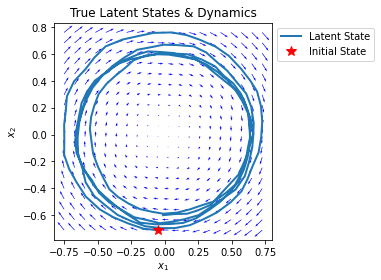

In [7]:
q = plot_dynamics_2d(true_lds._dynamics_distribution.weights, 
                     bias_vector=true_lds._dynamics_distribution.bias,
                     mins=states.min(axis=0),
                     maxs=states.max(axis=0),
                     color="blue")
plt.plot(states[:,0], states[:,1], lw=2, label="Latent State")
plt.plot(states[0,0], states[0,1], '*r', markersize=10, label="Initial State")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("True Latent States & Dynamics")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

### Plot the emissions 

The observed data are the outputs from the emissions of our model.

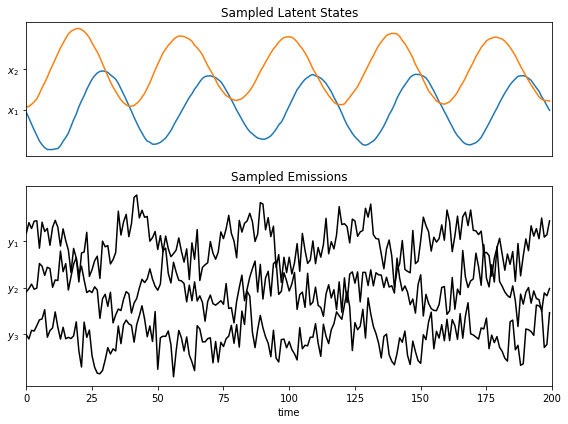

In [8]:
from matplotlib.gridspec import GridSpec 

plt.figure(figsize=(8, 6))
gs = GridSpec(2, 1, height_ratios=(1, emissions_dim / latent_dim))

# Plot the continuous latent states
lim = abs(states).max()
plt.subplot(gs[0])
for d in range(latent_dim):
    plt.plot(states[:, d] + lim * d, '-')
plt.yticks(np.arange(latent_dim) * lim, ["$x_{}$".format(d+1) for d in range(latent_dim)])
plt.xticks([])
plt.xlim(0, time_bins)
plt.title("Sampled Latent States")

lim = abs(data).max()
plt.subplot(gs[1])
for n in range(emissions_dim):
    plt.plot(data[:, n] - lim * n, '-k')
plt.yticks(-np.arange(emissions_dim) * lim, ["$y_{{ {} }}$".format(n+1) for n in range(emissions_dim)])
plt.xlabel("time")
plt.xlim(0, time_bins)

plt.title("Sampled Emissions")
plt.tight_layout()

# Inference

Can we fit an LDS model to the data generated by our ground-truth LDS from above?

In [9]:
emissions_dim = 3
latent_dim = 2
seed = jr.PRNGKey(32)
key1, key2 = jr.split(seed, 2)

initial_distribution = tfp.distributions.MultivariateNormalTriL(
    np.zeros(latent_dim), np.eye(latent_dim))

dynamics_distribution = GaussianLinearRegression(
    random_rotation(key1, latent_dim, theta=np.pi/20),
    np.zeros(latent_dim), 
    1.0**2 * np.eye(latent_dim))

emissions_distribution = GaussianLinearRegression(
    jr.normal(key2, shape=(emissions_dim, latent_dim)), 
    np.zeros(emissions_dim), 
    1.0**2 * np.eye(emissions_dim))

test_lds = GaussianLDS(initial_distribution, 
                       dynamics_distribution,
                       emissions_distribution)

### Maximizing the Marginal Log Probability

One way to fit our test linear dynamical system is by maximizing the marginal log probability using auto-differentiation. We import some handy helper functions from the `ssm.inference.lds` subpackage.

In [10]:
# from ssm.inference.lds import lds_log_normalizer, lds_expected_states

We construct our objective to be the negative of the (data-size normalized) marginal log probability.

Then, we can directly optimize our `test_lds` using an optimizer like Adam.

In [11]:
from ssm.distributions.mvn_block_tridiag import MultivariateNormalBlockTridiag, _forward_pass
from ssm.inference.lds import _exact_marginal_likelihood, _exact_e_step

100%|██████████| 1500/1500 [00:08<00:00, 166.78it/s]


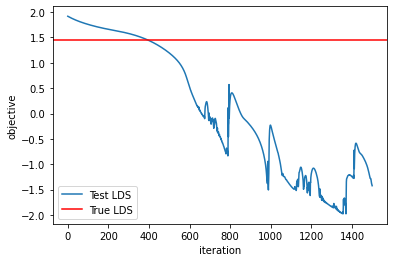

In [12]:
learning_rate = 0.001

def objective(lds):
    lp = _exact_marginal_likelihood(lds, data)
    return -1 * lp / data.size

opt_init, opt_update, get_params = optimizers.adam(learning_rate)
opt_state = opt_init(test_lds)

@jit
def step(step, opt_state):
    value, grads = value_and_grad(objective)(get_params(opt_state))
    opt_state = opt_update(step, grads, opt_state)
    return value, opt_state

vals = []
for i in trange(1500):
    value, opt_state = step(i, opt_state)
    vals.append(value)

plt.plot(vals, label="Test LDS")
plt.axhline(y=objective(true_lds).item(), xmin=0, xmax=1500, color="r", label="True LDS")
plt.xlabel("iteration")
plt.ylabel("objective")
plt.legend()
plt.show()

# Let's see how we did!

Here, we plot the ground truth dynamics / latent state trajectory alongside those inferred from the data.

868.09485


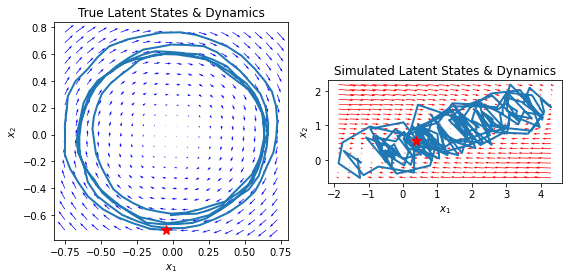

In [13]:
# Pull the fitted lds out of the latest opt_state
fitted_lds = get_params(opt_state)
posterior = _exact_e_step(fitted_lds, data)
Ex = posterior.mean
lp = _exact_marginal_likelihood(fitted_lds, data)
print(lp)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

q = plot_dynamics_2d(true_lds._dynamics_distribution.weights, 
                     bias_vector=true_lds._dynamics_distribution.bias,
                     mins=states.min(axis=0),
                     maxs=states.max(axis=0),
                     color="blue",
                     axis=axs[0])
axs[0].plot(states[:,0], states[:,1], lw=2)
axs[0].plot(states[0,0], states[0,1], '*r', markersize=10, label="$x_{init}$")
axs[0].set_xlabel("$x_1$")
axs[0].set_ylabel("$x_2$")
axs[0].set_title("True Latent States & Dynamics")

q = plot_dynamics_2d(fitted_lds._dynamics_distribution.weights, 
                     bias_vector=fitted_lds._dynamics_distribution.bias,
                     mins=Ex.min(axis=0),
                     maxs=Ex.max(axis=0),
                     color="red",
                     axis=axs[1])

axs[1].plot(Ex[:,0], posterior.mean[:,1], lw=2)
axs[1].plot(Ex[0,0], Ex[0,1], '*r', markersize=10, label="$x_{init}$")
axs[1].set_xlabel("$x_1$")
axs[1].set_ylabel("$x_2$")
axs[1].set_title("Simulated Latent States & Dynamics")
plt.tight_layout()
plt.show()

### Using Exact EM

We can derive exact M steps for Gaussian LDS (LDS with Gaussian observations). Let's take advantage of those analytical solutions by fitting our `test_lds` using EM.

LP: -857.018: 100%|██████████| 100/100 [00:04<00:00, 23.12it/s]


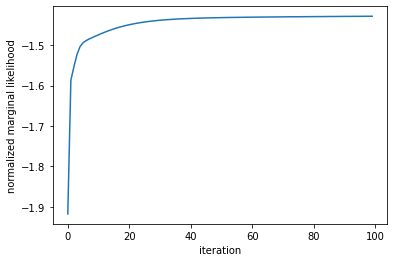

In [14]:
from ssm.inference.lds import em

lps, fitted_lds, posterior = em(test_lds, data)

plt.plot(lps / data.size)
plt.xlabel("iteration")
plt.ylabel("normalized marginal likelihood")
plt.show()

-857.0176


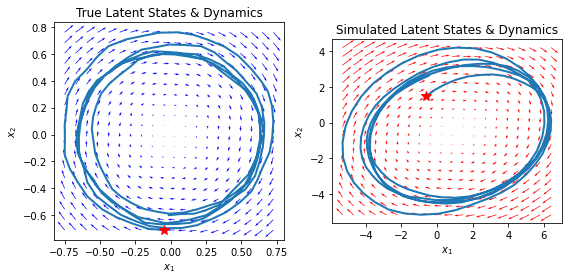

In [15]:
print(lps[-1])
Ex = posterior.mean

# Plot
num_batches_to_plot = 5
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

q = plot_dynamics_2d(true_lds._dynamics_distribution.weights, 
                     bias_vector=true_lds._dynamics_distribution.bias,
                     mins=states.min(axis=0),
                     maxs=states.max(axis=0),
                     color="blue",
                     axis=axs[0])
axs[0].plot(states[:,0], states[:,1], lw=2)
axs[0].plot(states[0,0], states[0,1], '*r', markersize=10, label="$x_{init}$")
axs[0].set_xlabel("$x_1$")
axs[0].set_ylabel("$x_2$")
axs[0].set_title("True Latent States & Dynamics")

q = plot_dynamics_2d(fitted_lds._dynamics_distribution.weights, 
                     bias_vector=fitted_lds._dynamics_distribution.bias,
                     mins=Ex.min(axis=0),
                     maxs=Ex.max(axis=0),
                     color="red",
                     axis=axs[1])

axs[1].plot(Ex[:,0], Ex[:,1], lw=2)
axs[1].plot(Ex[0,0], Ex[0,1], '*r', markersize=10, label="$x_{init}$")
axs[1].set_xlabel("$x_1$")
axs[1].set_ylabel("$x_2$")
axs[1].set_title("Simulated Latent States & Dynamics")
plt.tight_layout()
plt.show()

# Batch Inference

Before, we fit our `test_lds` using only one sampled trajectory from the true LDS model. What if we have multiple, i.i.d. trajectories from this system that we could use to better fit our model?

Using JAX's `jax.vmap` functionality, we can easily extend our previous work to work with a batch of trajectories.

### Generate a batch of trajectories

Here, we sample 100 different trajectories from the underlying, true LDS.

In [16]:
batch_size = 100
states = []
data = []
keys = jr.split(key, batch_size)
for batch_idx in trange(batch_size):
    s, d = true_lds.sample(key=keys[batch_idx], num_steps=time_bins)
    states.append(s)
    data.append(d)
states = np.stack(states)
data = np.stack(data)

100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


### Visualize the Dynamics / Latent States

As before, we can visualize the sampled latent states (here, with the multiple trajectories).

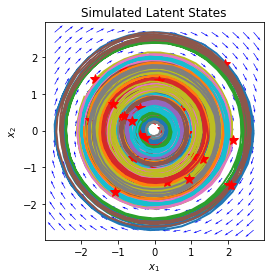

In [17]:
# Plot the dynamics vector field
q = plot_dynamics_2d(true_lds._dynamics_distribution.weights, 
                     bias_vector=true_lds._dynamics_distribution.bias,
                     mins=states.min(axis=(0, 1)),
                     maxs=states.max(axis=(0, 1)),
                     color="blue")

for batch_idx in range(batch_size):
    plt.plot(states[batch_idx][:,0], states[batch_idx][:,1], lw=2)
    plt.plot(states[batch_idx][0,0], states[batch_idx][0,1], '*r', markersize=10)        

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Simulated Latent States")
plt.tight_layout()
# plt.legend()
plt.show()

100%|██████████| 1500/1500 [00:52<00:00, 28.33it/s]


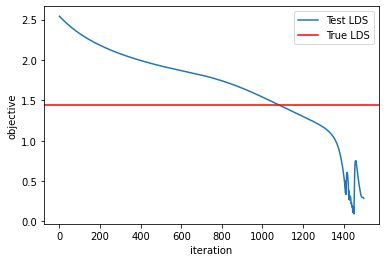

In [24]:

learning_rate = 0.0005

def objective(lds):
    f = lambda y: _exact_marginal_likelihood(lds, y)
    lps = vmap(f)(data)
    return -np.sum(lps) / data.size

opt_init, opt_update, get_params = optimizers.adam(learning_rate)
opt_state = opt_init(test_lds)

@jit
def step(step, opt_state):
    value, grads = value_and_grad(objective)(get_params(opt_state))
    opt_state = opt_update(step, grads, opt_state)
    return value, opt_state

vals = []
for i in trange(1500):
    value, opt_state = step(i, opt_state)
    vals.append(value)

plt.plot(vals, label="Test LDS")
plt.axhline(y=objective(true_lds).item(), xmin=0, xmax=1500, color="r", label="True LDS")
plt.xlabel("iteration")
plt.ylabel("objective")
plt.legend()
plt.show()

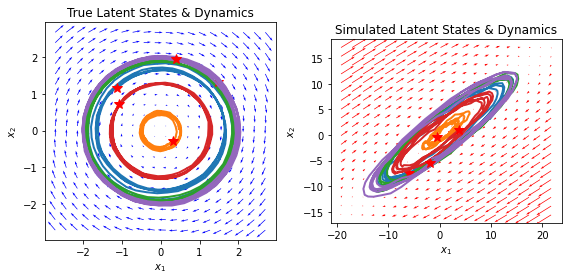

In [25]:
# Pull the fitted lds out of the latest opt_state
fitted_lds = get_params(opt_state)

# Batch inference
# lp, Ex, ExxT, ExnxT = vmap(lds_expected_states)(*vmap(fitted_lds.natural_parameters)(data))
# print(lp.mean())
f = lambda y: _exact_e_step(fitted_lds, y).mean
Ex = vmap(f)(data)

# Plot
num_batches_to_plot = 5
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

q = plot_dynamics_2d(true_lds._dynamics_distribution.weights, 
                     bias_vector=true_lds._dynamics_distribution.bias,
                     mins=states.min(axis=(0, 1)),
                     maxs=states.max(axis=(0, 1)),
                     color="blue",
                     axis=axs[0])
for batch_idx in range(num_batches_to_plot):
    axs[0].plot(states[batch_idx][:,0], states[batch_idx][:,1], lw=2)
    axs[0].plot(states[batch_idx][0,0], states[batch_idx][0,1], '*r', markersize=10, label="$x_{init}$")
axs[0].set_xlabel("$x_1$")
axs[0].set_ylabel("$x_2$")
axs[0].set_title("True Latent States & Dynamics")

q = plot_dynamics_2d(fitted_lds._dynamics_distribution.weights, 
                     bias_vector=fitted_lds._dynamics_distribution.bias,
                     mins=Ex.min(axis=(0, 1)),
                     maxs=Ex.max(axis=(0, 1)),
                     color="red",
                     axis=axs[1])

for batch_idx in range(num_batches_to_plot):
    axs[1].plot(Ex[batch_idx][:,0], Ex[batch_idx][:,1], lw=2)
    axs[1].plot(Ex[batch_idx][0,0], Ex[batch_idx][0,1], '*r', markersize=10, label="$x_{init}$")
axs[1].set_xlabel("$x_1$")
axs[1].set_ylabel("$x_2$")
axs[1].set_title("Simulated Latent States & Dynamics")
plt.tight_layout()
plt.show()